<a href="https://colab.research.google.com/github/tablehan/deepLearningPractice/blob/main/LSTMforCCI30_practice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import math
import pandas_datareader as web
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
import matplotlib.pyplot as plt
import time
import datetime
import os
print(os.path.abspath(''))

/content


In [5]:
# 從網路直接抓cci30過來測試建模
df=pd.read_csv("https://cci30.com/ajax/getIndexHistory.php",index_col=0).iloc[::-1,:]
print(df.shape)
# 空值處理
print(df.isnull().sum())
print(df[df["Volume"].isnull()])
# 取前後兩日差平均差補
df.loc['2020-11-30','Volume']=(df.loc['2020-12-01','Volume']+df.loc['2020-11-29','Volume'])/2
print(df.loc[['2020-11-29','2020-11-30','2020-12-01'],:])
# 排除成交量為0者
# exclude periods that valume=0
df=df[df['Volume']>0]
print(df.shape)

(2833, 5)
Open      0
High      0
Low       0
Close     0
Volume    1
dtype: int64
               Open     High      Low   Close  Volume
Date                                                 
2020-11-30  6327.62  6807.17  6270.84  6746.8     NaN
               Open     High      Low    Close        Volume
Date                                                        
2020-11-29  6270.79  6498.38  6133.79  6407.27  9.380875e+10
2020-11-30  6327.62  6807.17  6270.84  6746.80  1.127981e+11
2020-12-01  6748.96  6899.90  6220.79  6394.38  1.317874e+11
(1678, 5)


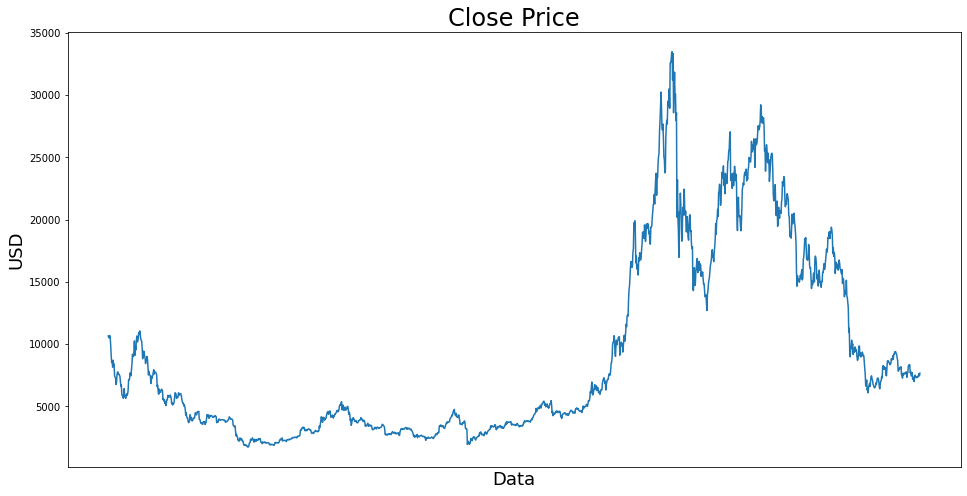

In [6]:
plt.figure(figsize=(16,8))
plt.title('Close Price', fontsize=24)
plt.plot(df['Close'])
plt.xticks([])
plt.xlabel('Data', fontsize=18)
plt.ylabel('USD', fontsize=18)
plt.show()

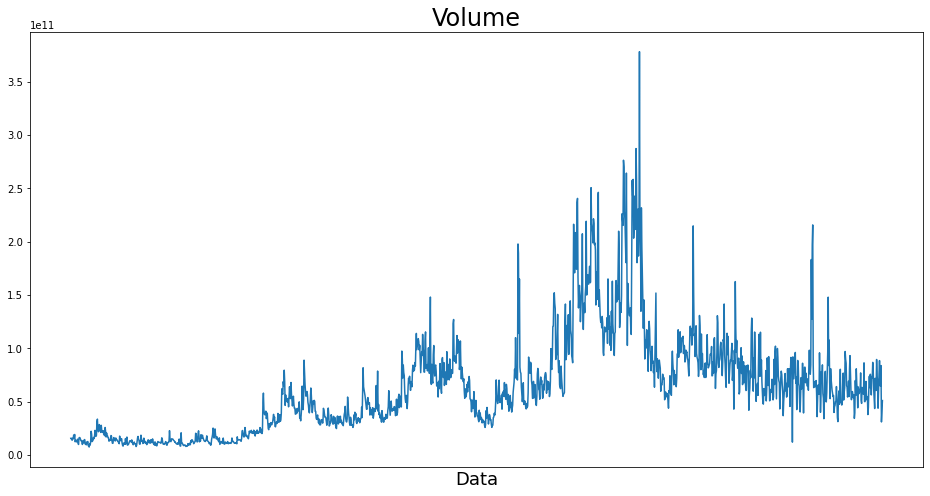

In [7]:
plt.figure(figsize=(16,8))
plt.title('Volume', fontsize=24)
plt.plot(df['Volume'])
plt.xticks([])
plt.xlabel('Data', fontsize=18)
plt.show()

In [8]:
# Get the number of rows to train the model on. we need this number to create our train and test sets
# math.ceil will round up the number
training_data_len = math.ceil(df.shape[0] * .8) # We are using %80 of the data for training
training_data_len

1343

In [9]:
# Scale the data with MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(df)
print(scaled_data)

[[0.26718113 0.27445008 0.28023588 0.28102918 0.02205259]
 [0.28119915 0.27450425 0.28790962 0.27647164 0.0224575 ]
 [0.27647607 0.27319202 0.28864061 0.27661967 0.0184771 ]
 ...
 [0.1875497  0.18052385 0.19776496 0.18567476 0.06346625]
 [0.18574869 0.17877823 0.19385234 0.1805761  0.08785244]
 [0.1806431  0.17901298 0.19275255 0.18686501 0.11753914]]


In [18]:
# hyper param
timeStep=10
batch_size=4
epochs=100
d=0.2

In [11]:
# Creat the training dataset
train_data = scaled_data[0:training_data_len, :]

#Split the data into X_train and y_train data sets
X_train = np.array([train_data[i-timeStep:i,:] for i in range(timeStep, len(train_data))])
y_train = np.array([train_data[i,:] for i in range(timeStep, len(train_data))])
print(f'X_train shape:{X_train.shape}',f'y_train_shape: {y_train.shape}')

X_train shape:(1333, 10, 5) y_train_shape: (1333, 5)


In [12]:
# Create the testing dataset
# Create a new array containing scaled values from index 1335
test_data = scaled_data[training_data_len - timeStep : , :]
test_data
X_test = np.array([test_data[i-timeStep: i,:] for i in range(timeStep,len(test_data))])
y_test = np.array([test_data[i,:] for i in range(timeStep, len(test_data))])
print(f'X_test shape:{X_test.shape}',f'y_test_shape: {y_test.shape}')

X_test shape:(335, 10, 5) y_test_shape: (335, 5)


In [19]:
# Build LSTM model
tf.random.set_seed(42)
model_1 = Sequential()
model_1.add(LSTM(64, return_sequences=True, input_shape=(timeStep, X_train.shape[-1])))
model_1.add(Dropout(d))
model_1.add(LSTM(64, return_sequences=False))
model_1.add(Dropout(d))
model_1.add(Dense(32))
model_1.add(Dense(5))

In [20]:
# Compile the model
model_1.compile(optimizer='adam', loss='mse')
print(model_1.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 10, 64)            17920     
                                                                 
 dropout_2 (Dropout)         (None, 10, 64)            0         
                                                                 
 lstm_3 (LSTM)               (None, 64)                33024     
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 5)                 165       
                                                                 
Total params: 53,189
Trainable params: 53,189
Non-trai

In [21]:
# Train the model
start_fix_time=datetime.datetime.now()
print(start_fix_time)
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=2)
history = model_1.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, verbose=2, validation_data=(X_test,y_test))

end_fix_time=datetime.datetime.now()
print(end_fix_time)

2022-10-05 04:17:48.689520
Epoch 1/100
334/334 - 6s - loss: 0.0051 - val_loss: 0.0021 - 6s/epoch - 18ms/step
Epoch 2/100
334/334 - 2s - loss: 0.0026 - val_loss: 0.0018 - 2s/epoch - 5ms/step
Epoch 3/100
334/334 - 2s - loss: 0.0024 - val_loss: 0.0026 - 2s/epoch - 6ms/step
Epoch 4/100
334/334 - 2s - loss: 0.0023 - val_loss: 0.0020 - 2s/epoch - 6ms/step
Epoch 5/100
334/334 - 2s - loss: 0.0019 - val_loss: 0.0014 - 2s/epoch - 5ms/step
Epoch 6/100
334/334 - 2s - loss: 0.0018 - val_loss: 0.0017 - 2s/epoch - 5ms/step
Epoch 7/100
334/334 - 2s - loss: 0.0020 - val_loss: 0.0038 - 2s/epoch - 5ms/step
Epoch 8/100
334/334 - 2s - loss: 0.0016 - val_loss: 0.0015 - 2s/epoch - 5ms/step
Epoch 9/100
334/334 - 2s - loss: 0.0015 - val_loss: 0.0014 - 2s/epoch - 5ms/step
Epoch 10/100
334/334 - 2s - loss: 0.0018 - val_loss: 0.0011 - 2s/epoch - 6ms/step
Epoch 11/100
334/334 - 2s - loss: 0.0015 - val_loss: 0.0013 - 2s/epoch - 6ms/step
Epoch 12/100
334/334 - 2s - loss: 0.0016 - val_loss: 0.0026 - 2s/epoch - 5ms/st

<function matplotlib.pyplot.show(*args, **kw)>

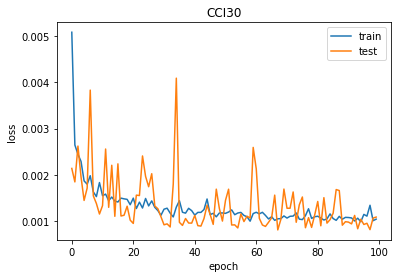

In [22]:
# plot the loss graph
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.title('CCI30',fontsize='12')
plt.ylabel('loss',fontsize='10')
plt.xlabel('epoch',fontsize='10')
plt.legend()
plt.show

In [23]:
# Get the model_1 predicted price values 
predictions_1 = model_1.predict(X_test)
predictions_1 = scaler.inverse_transform(predictions_1)
predictions_1[:5,:]

array([[2.60412539e+04, 2.73433906e+04, 2.48619062e+04, 2.58890469e+04,
        1.29085981e+11],
       [2.65217344e+04, 2.78088770e+04, 2.54045410e+04, 2.63648535e+04,
        1.28099385e+11],
       [2.64189395e+04, 2.76933691e+04, 2.53145312e+04, 2.62678203e+04,
        1.23370209e+11],
       [2.63276387e+04, 2.75964805e+04, 2.52296504e+04, 2.61829199e+04,
        1.21245155e+11],
       [2.63275977e+04, 2.75220449e+04, 2.53478535e+04, 2.61944688e+04,
        1.09101081e+11]], dtype=float32)

In [24]:
#plotting param
dic={0:"Open",1:"High",2:"Low",3:"Close",4:"Volume"}
nums=0

In [25]:
# measure
from sklearn.metrics import mean_squared_error, r2_score
y_inver=scaler.inverse_transform(y_test)
for i in dic.keys():
  MAE=mean_squared_error(predictions_1[i], y_inver[i])
  R2=r2_score(predictions_1[i], y_inver[i])
  print(f'{dic[i]}: Mean Absolute Error={MAE} , | R2={R2}')
MAE=mean_squared_error(predictions_1, y_inver)
R2=r2_score(predictions_1, y_inver)
print(f'Total: Mean Absolute Error={MAE} , | R2={R2}')

Open: Mean Absolute Error=1.102291572616492e+20 , | R2=0.958655424802452
High: Mean Absolute Error=1.7307483271985722e+20 , | R2=0.9340795707237305
Low: Mean Absolute Error=2.433970058119814e+20 , | R2=0.9000518399753907
Close: Mean Absolute Error=4.397605479462479e+20 , | R2=0.8130318177611063
Volume: Mean Absolute Error=1.0461112354146125e+20 , | R2=0.9450712167888894
Total: Mean Absolute Error=1.0004121704077951e+20 , | R2=0.7461024768009381


Text(0.5, 0, 'epochs')

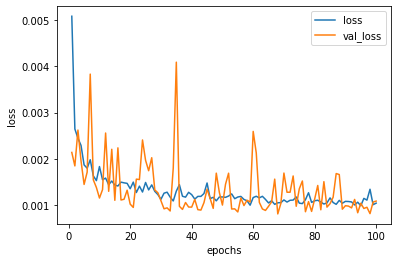

In [26]:
# Let's plot the history of model_1 and see what's going on
historyForPlot = pd.DataFrame(history.history)
historyForPlot.index += 1 # we plus 1 to the number of indexing so our epochs Plot picture will be counting from 1 not 0.
historyForPlot.plot()
plt.ylabel("loss")
plt.xlabel("epochs")

In [ ]:
# reference
# https://github.com/Ali619/Bitcoin-Price-Prediction-LSTM/blob/master/Bitcoin_Price_Prediction.ipynb

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


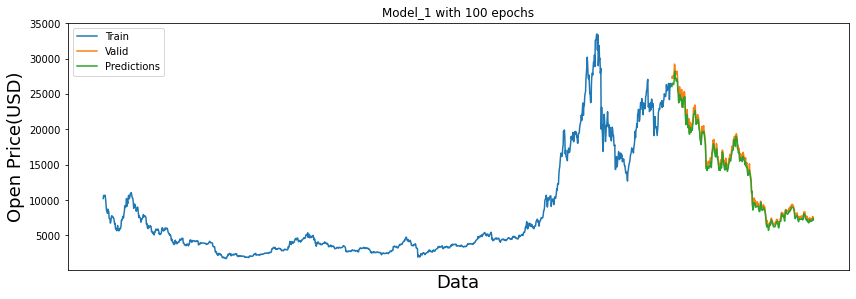

In [31]:
# Plot the data
train = df.iloc[:training_data_len]
# data for model_1
valid_1 = df.iloc[training_data_len:,:]
valid_1['Predictions'] = predictions_1[:,nums]

plt.figure(figsize=(14, 10))
plt.subplot(2, 1, 1)
plt.title(f'Model_1 with {epochs} epochs')
plt.xticks([])
plt.xlabel('Data', fontsize=18)
plt.ylabel(f'{dic[nums] if nums==4 else dic[nums]+" Price(USD)"}', fontsize=18)
plt.plot(train[dic[nums]])
plt.plot(valid_1[[dic[nums],"Predictions"]])
plt.legend(['Train', 'Valid', 'Predictions'], loc='upper left')

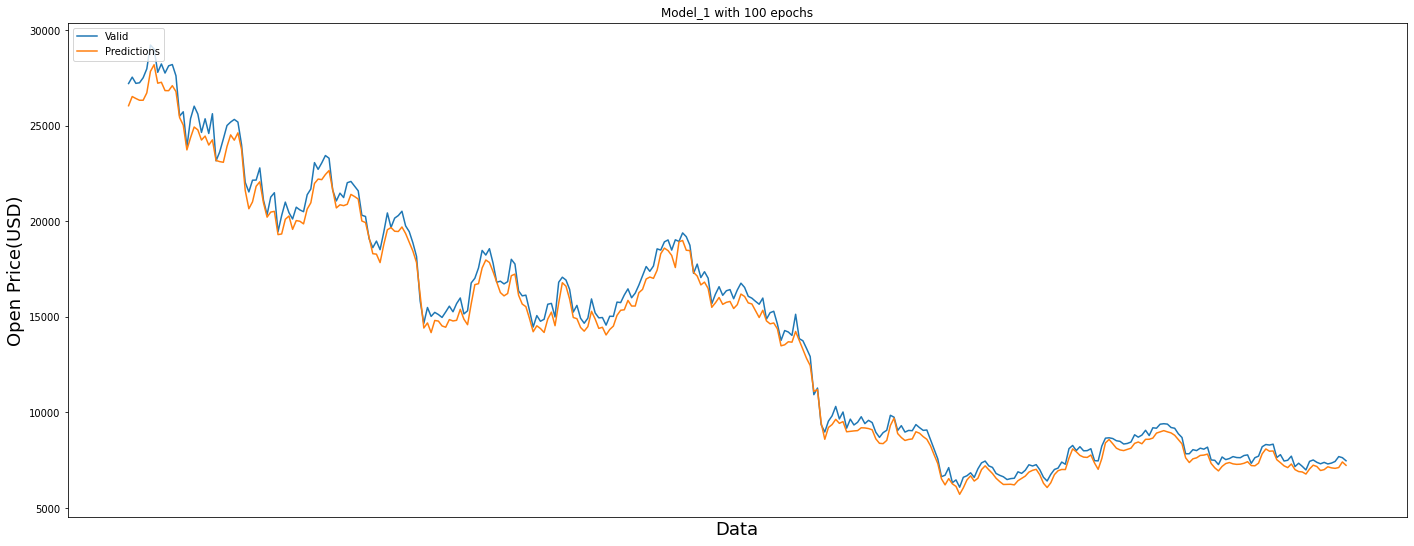

In [30]:
plt.figure(figsize=(24, 20))
plt.subplot(2, 1, 1)
plt.title(f'Model_1 with {epochs} epochs')
plt.xticks([])
plt.xlabel('Data', fontsize=18)
plt.ylabel(f'{dic[nums] if nums==4 else dic[nums]+" Price(USD)"}', fontsize=18)
plt.plot(valid_1[[dic[nums],"Predictions"]])
plt.legend(['Valid', 'Predictions'], loc='upper left')

In [29]:
 model_1.save('models/bdse27_lstm_model.h5')